In [1]:
%matplotlib inline
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import copy
import torch.nn as nn
import torch.nn.functional as F

import time

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop( (224,224) ),
        transforms.ToTensor(),

    ]),
    'val': transforms.Compose([
        transforms.CenterCrop( (224,224) ),
        transforms.ToTensor(),
    ]),
}

data_dir = '/disk1/projects/lectures/ml_lectures/day_6/data/lang/data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [41]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(inp)
    plt.show()

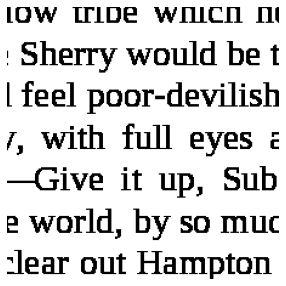

****************************************************************************************************


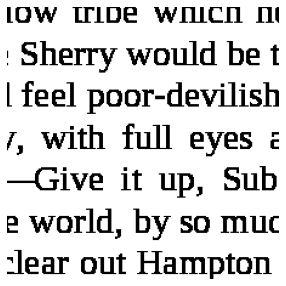

****************************************************************************************************


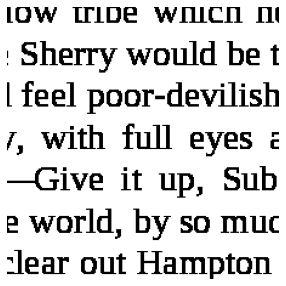

****************************************************************************************************


In [43]:
for i in range(3):
    im1,_ = image_datasets['train'][0]
    imshow(im1)
    print(100*"*")

In [24]:
class LangDetector(nn.Module):
    def __init__(self):
        super(LangDetector, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        self.fc1 = nn.Linear(128*26*26, 128)
        self.fc2 = nn.Linear(128, 3)
         

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 128*26*26)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        
        return x 
        
        
model = LangDetector()

ret = model( im1.unsqueeze(0) )
ret.shape

torch.Size([1, 3])

In [25]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                if scheduler:
                    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:

model = LangDetector()

optimizer = torch.optim.Adam( model.parameters())

criterion  = torch.nn.CrossEntropyLoss()
 

In [27]:
train_model(model, criterion, optimizer, scheduler=None)

Epoch 0/9
----------
train Loss: 1.1586 Acc: 0.4076
val Loss: 1.2315 Acc: 0.3148

Epoch 1/9
----------
train Loss: 1.1238 Acc: 0.3950
val Loss: 1.0170 Acc: 0.5741

Epoch 2/9
----------
train Loss: 1.0031 Acc: 0.5210
val Loss: 0.7861 Acc: 0.6296

Epoch 3/9
----------
train Loss: 0.7262 Acc: 0.6975
val Loss: 0.5023 Acc: 0.7778

Epoch 4/9
----------
train Loss: 0.4125 Acc: 0.8361
val Loss: 0.3664 Acc: 0.8704

Epoch 5/9
----------
train Loss: 0.2561 Acc: 0.9118
val Loss: 0.3006 Acc: 0.8333

Epoch 6/9
----------
train Loss: 0.1200 Acc: 0.9496
val Loss: 0.2876 Acc: 0.8889

Epoch 7/9
----------
train Loss: 0.0785 Acc: 0.9706
val Loss: 0.3064 Acc: 0.9074

Epoch 8/9
----------
train Loss: 0.0761 Acc: 0.9664
val Loss: 0.1776 Acc: 0.9074

Epoch 9/9
----------
train Loss: 0.0626 Acc: 0.9748
val Loss: 0.2729 Acc: 0.8889

Training complete in 11m 29s
Best val Acc: 0.907407


LangDetector(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

((4486, 150, 150, 1), (4486, 3), (1122, 150, 150, 1), (1122, 3))

In [50]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure() #figsize=(10,10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                
                ax.axis('off')
                #ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                print('predicted: {}'.format(class_names[preds[j]]))
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                print( 100*"*")
        model.train(mode=was_training)

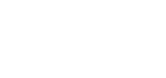

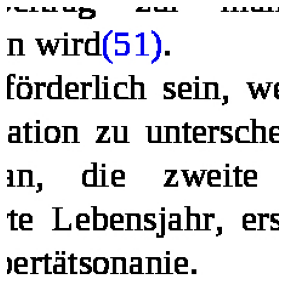

predicted: ger
****************************************************************************************************


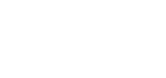

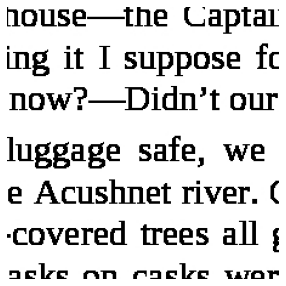

predicted: swe
****************************************************************************************************


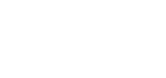

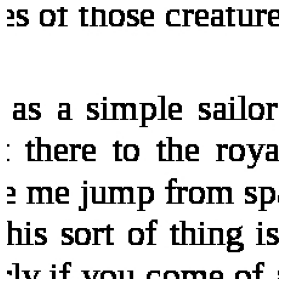

predicted: en
****************************************************************************************************


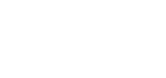

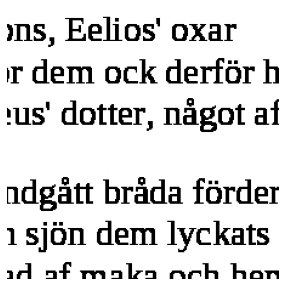

predicted: swe
****************************************************************************************************


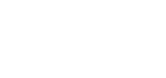

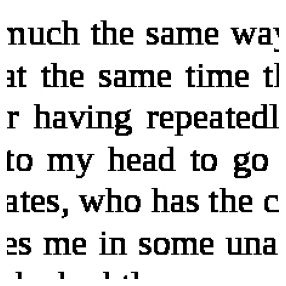

predicted: en
****************************************************************************************************


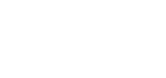

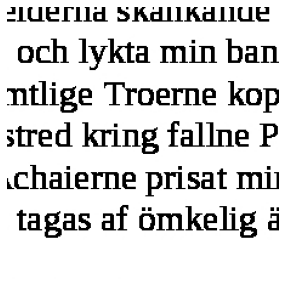

predicted: swe


In [51]:
visualize_model(model)